In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
import math
from PIL import Image
import random
import matplotlib.image as mpimg
from imutils import paths
import sys
import operator

In [3]:
!pip install rich
!pip install hydra-core
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 235 kB 5.1 MB/s 
     |████████████████████████████████| 51 kB 5.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 151 kB 5.1 MB/s 
     |████████████████████████████████| 79 kB 7.4 MB/s 
     |████████████████████████████████| 117 kB 43.5 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=8f94c8e20ea8b505bd97cc6ff75484d240940c7d5a593a6a1c227f3d11466076
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 706 kB 5.3 MB/s 
     |████████████████████████████████| 5.9 MB 50.7 MB/s 
     |████████████████████████████████| 419 kB 46.3 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [4]:
sys.path.insert(0, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation")
sys.path.insert(1, "/content/drive/MyDrive/Github_Repos/historia_ml_handwritten_text_line_segmentation/src/utils")

In [5]:
import pytorch_lightning as pl
from src.utils.display_image_from_path import img_show
from src.utils.display_image_from_array import img_show_from_arr
from src.utils.delete_border_lines import delete_border_lines
from src.utils.take_pixels_whose_neighbors_are_zero import next_neighbor_as_zero
from src.utils.get_row_heights import get_row_heights
from src.utils.get_col_widths import get_col_widths
from src.utils.erase_short_lines import erase_lines_with_small_width
from src.utils.erase_small_lines import erase_lines_with_small_height
from src.utils.find_image_page_type import find_image_page_type
from src.utils.create_row_patches_from_lines_y_coordinates import create_row_patches
from src.utils.get_unique_cols_from_row_patches import create_unique_patch_cols
from src.utils.create_row_patch_mapping import get_patch_map
from src.utils.create_bboxes import create_bbox_list
from src.utils.create_line_images_from_bbox import create_line_image_from_bbox
from src.utils.create_row_images_from_bbox_list import create_row_images
from src.utils.get_bboxes_from_mask import get_bboxes_from_mask
from src.utils.save_line_images import save_line_images
from src.utils.save_line_images_v2 import save_line_images_v2
from src.utils.display_and_save_line_images import display_and_save_line_images
from src.utils.calculate_the_safety_gaps import calculate_safety_gap_xy
from src.utils.preprocess_img_mask import preprocess_erasing

In [6]:
img_path = "/content/drive/MyDrive/Images/esad-129.png"
img = cv2.imread(img_path)
img_mask = cv2.imread("/content/drive/MyDrive/output/test_page_predicted_masks/esad-129_mask_313x313.png")

img_show_from_arr(img)
img_show_from_arr(img_mask)

Output hidden; open in https://colab.research.google.com to view.

In [7]:
cfg = {
    "img_path": img_path,
    "x_ratio": 0.07,
    "y_ratio": 0.1,
    "col_width_limit_ratio": 0.7,
    "row_height_limit_ratio": 0.2,
    "line_gap_ratio": 0.06,
    "safety_gap_x_ratio": 0.05,
    "safety_gap_y_ratio": 0.3,
    "safety_erase_ratio_width": 0.01,
    "safety_erase_ratio_height": 0.01,
    "patch_unique_col_size_limit_ratio": 0.5,
    "lower_freq_y_ratio": 0.7,
    "higher_freq_y_ratio": 2,
    "lower_freq_x_ratio":0.3
}

In [8]:
mask = img_mask.copy()
mask = preprocess_erasing(mask, cfg["x_ratio"], cfg["y_ratio"], cfg["lower_freq_y_ratio"], cfg["higher_freq_y_ratio"], cfg["lower_freq_x_ratio"])

mask_coords = next_neighbor_as_zero(mask)
mask = np.zeros(mask.shape)
for coord in mask_coords:
  mask[coord[0]][coord[1]][0] = 255
  mask[coord[0]][coord[1]][1] = 255
  mask[coord[0]][coord[1]][2] = 255

mask_cols = []
for coord in mask_coords:
  mask_cols.append(coord[1])
mask_unique_cols = np.unique(np.array(mask_cols))

bbox_xcoords = []
bbox_xcoords.append(mask_unique_cols[0])
for i in range(len(mask_unique_cols)-1):
  if abs(mask_unique_cols[i] - mask_unique_cols[i+1]) > 3:
    bbox_xcoords.append(mask_unique_cols[i])
    bbox_xcoords.append(mask_unique_cols[i+1])
bbox_xcoords.append(mask_unique_cols[-1])
bbox_xcoords_pair = [(bbox_xcoords[i], bbox_xcoords[i+1]) for i in range(0, len(bbox_xcoords), 2)]

line_widths = get_col_widths(bbox_xcoords_pair)
mean_line_width = np.mean(line_widths)
line_width_limit = mean_line_width * cfg["col_width_limit_ratio"]

mask = erase_lines_with_small_width(mask, bbox_xcoords_pair, cfg["safety_erase_ratio_width"], line_width_limit)

mask_coords = next_neighbor_as_zero(mask)
mask_rows = []
for coord in mask_coords:
  mask_rows.append(coord[0])
mask_unique_rows = np.unique(np.array(mask_rows))

bbox_ycoords = []
bbox_ycoords.append(mask_unique_rows[0])
for i in range(len(mask_unique_rows)-1):
  if abs(mask_unique_rows[i] - mask_unique_rows[i+1]) > 3:
    bbox_ycoords.append(mask_unique_rows[i])
    bbox_ycoords.append(mask_unique_rows[i+1])
bbox_ycoords.append(mask_unique_rows[-1])
bbox_ycoords_pair = [(bbox_ycoords[i], bbox_ycoords[i+1]) for i in range(0, len(bbox_ycoords), 2)]

line_heights = get_row_heights(bbox_ycoords_pair)
mean_line_height = np.mean(line_heights)
line_height_limit = mean_line_height * cfg["row_height_limit_ratio"]

mask = erase_lines_with_small_height(mask, bbox_ycoords_pair, cfg["safety_erase_ratio_height"], line_height_limit)

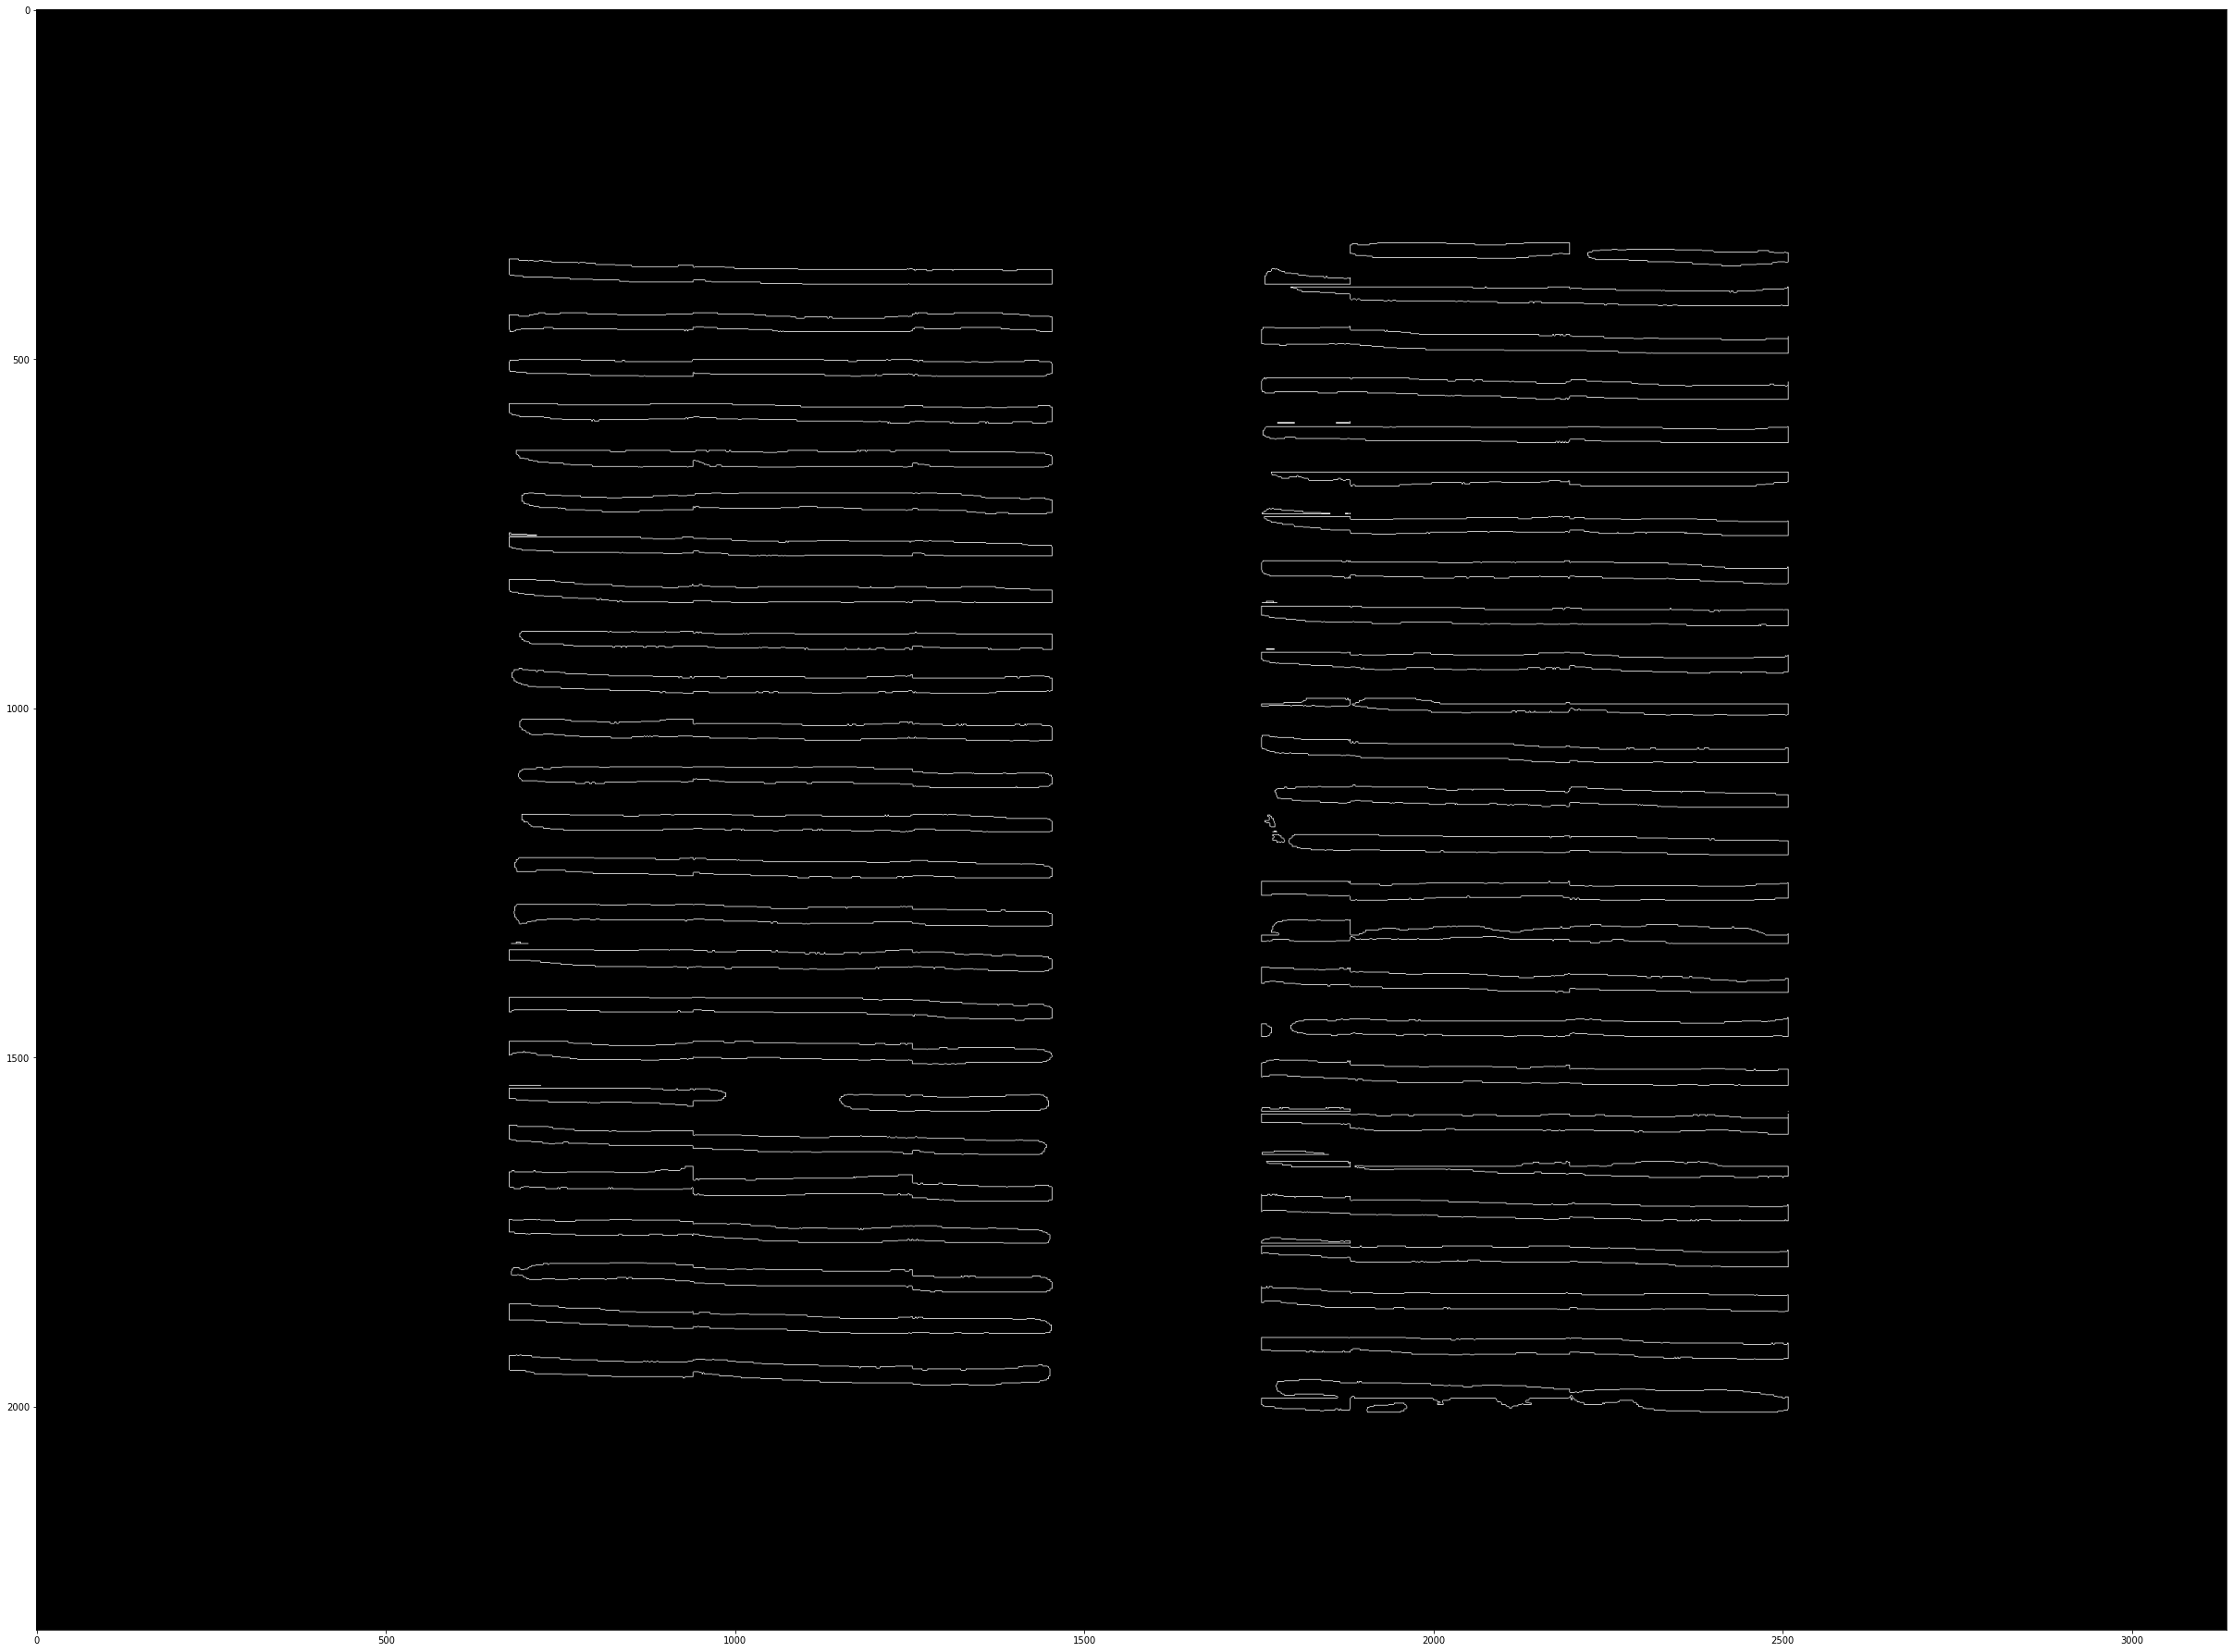

In [9]:
img_show_from_arr(mask)

In [10]:
mask_coords = next_neighbor_as_zero(mask)
mask_left_page_coords = []
mask_right_page_coords = []
mask_xcoords = []
mask_ycoords = []
for coord in mask_coords:
  mask_xcoords.append(coord[1])
  mask_ycoords.append(coord[0])

unique_mask_xcoords = np.unique(np.array(mask_xcoords))
unique_mask_ycoords = np.unique(np.array(mask_ycoords))

h, w, d = mask.shape

bbox_x1x2 = []
bbox_y1y2 = []
bbox_x1x2.append(unique_mask_xcoords[0])
for i in range(len(unique_mask_xcoords)-1):
  if abs(unique_mask_xcoords[i] - unique_mask_xcoords[i+1]) > w // 250:
    bbox_x1x2.append(unique_mask_xcoords[i])
    bbox_x1x2.append(unique_mask_xcoords[i+1])
bbox_x1x2.append(unique_mask_xcoords[-1])

bbox_y1y2.append(unique_mask_ycoords[0])
for i in range(len(unique_mask_ycoords)-1):
  if abs(unique_mask_ycoords[i] - unique_mask_ycoords[i+1]) > h // 250:
    bbox_y1y2.append(unique_mask_ycoords[i])
    bbox_y1y2.append(unique_mask_ycoords[i+1])
bbox_y1y2.append(unique_mask_ycoords[-1])

bbox_xpairs = [(bbox_x1x2[i], bbox_x1x2[i+1]) for i in range(0, len(bbox_x1x2)-1, 2)]
mask_line_widths = get_col_widths(bbox_xpairs)
main_line_threshold = np.mean(np.array(mask_line_widths)) * 0.95

main_line_chunks = []
for pair in bbox_xpairs:
  if abs(pair[0] - pair[1]) > main_line_threshold:
    main_line_chunks.append(pair)
pages_center_line = (main_line_chunks[0][1] + main_line_chunks[1][0]) // 2

for coord in mask_coords:
  if coord[1] < pages_center_line:
    mask_left_page_coords.append(coord)
  else:
    mask_right_page_coords.append(coord)

mask_left_page = np.zeros((h, pages_center_line, d))
mask_right_page = np.zeros((h, w - pages_center_line, d))

hl, wl, dl = mask_left_page.shape
hr, wr, dr = mask_right_page.shape
mask_right_page_subtracted_coords = []
for coord in mask_right_page_coords:
  coord = list(coord)
  coord[1] = coord[1] - wl
  coord = tuple(coord)
  mask_right_page_subtracted_coords.append(coord)

for coord in mask_left_page_coords:
  mask_left_page[coord[0]][coord[1]][0] = 255
  mask_left_page[coord[0]][coord[1]][1] = 255
  mask_left_page[coord[0]][coord[1]][2] = 255

for coord in mask_right_page_subtracted_coords:
  mask_right_page[coord[0]][coord[1]][0] = 255
  mask_right_page[coord[0]][coord[1]][1] = 255
  mask_right_page[coord[0]][coord[1]][2] = 255

In [ ]:
img_show_from_arr(mask_left_page)
img_show_from_arr(mask_right_page)

In [ ]:
mask_left_page_coords = next_neighbor_as_zero(mask_left_page)
mask_right_page_coords = next_neighbor_as_zero(mask_right_page)

mask_left_page_xcoords = []
mask_left_page_ycoords = []
mask_right_page_xcoords = []
mask_right_page_ycoords = []
for coord in mask_left_page_coords:
  mask_left_page_xcoords.append(coord[1])
  mask_left_page_ycoords.append(coord[0])

for coord in mask_right_page_coords:
  mask_right_page_xcoords.append(coord[1])
  mask_right_page_ycoords.append(coord[0])

mask_left_page_unique_xcoords = np.unique(np.array(mask_left_page_xcoords))
mask_left_page_unique_ycoords = np.unique(np.array(mask_left_page_ycoords))
mask_right_page_unique_xcoords = np.unique(np.array(mask_right_page_xcoords))
mask_right_page_unique_ycoords = np.unique(np.array(mask_right_page_ycoords))

mask_left_bbox_xcoords = []
mask_right_bbox_xcoords = []

mask_left_bbox_xcoords.append(mask_left_page_unique_xcoords[0])
for i in range(len(mask_left_page_unique_xcoords)-1):
  if abs(mask_left_page_unique_xcoords[i] - mask_left_page_unique_xcoords[i+1]) > wl // 250:
    mask_left_bbox_xcoords.append(mask_left_page_unique_xcoords[i])
    mask_left_bbox_xcoords.append(mask_left_page_unique_xcoords[i+1])
mask_left_bbox_xcoords.append(mask_left_page_unique_xcoords[-1])

mask_right_bbox_xcoords.append(mask_right_page_unique_xcoords[0])
for i in range(len(mask_right_page_unique_xcoords)-1):
  if abs(mask_right_page_unique_xcoords[i] - mask_right_page_unique_xcoords[i+1]) > wr // 250:
    mask_right_bbox_xcoords.append(mask_right_page_unique_xcoords[i])
    mask_right_bbox_xcoords.append(mask_right_page_unique_xcoords[i+1])
mask_right_bbox_xcoords.append(mask_right_page_unique_xcoords[-1])

mask_left_bbox_xpairs = [(mask_left_bbox_xcoords[i], mask_left_bbox_xcoords[i+1]) for i in range(0, len(mask_left_bbox_xcoords)-1, 2)]
mask_right_bbox_xpairs = [(mask_right_bbox_xcoords[i], mask_right_bbox_xcoords[i+1]) for i in range(0, len(mask_right_bbox_xcoords)-1, 2)]

mask_left_bbox_ycoords = []
mask_right_bbox_ycoords = []

mask_left_bbox_ycoords.append(mask_left_page_unique_ycoords[0])
for i in range(len(mask_left_page_unique_ycoords)-1):
  if abs(mask_left_page_unique_ycoords[i] - mask_left_page_unique_ycoords[i+1]) > hl // 250:
    mask_left_bbox_ycoords.append(mask_left_page_unique_ycoords[i])
    mask_left_bbox_ycoords.append(mask_left_page_unique_ycoords[i+1])
mask_left_bbox_ycoords.append(mask_left_page_unique_ycoords[-1])

mask_right_bbox_ycoords.append(mask_right_page_unique_ycoords[0])
for i in range(len(mask_right_page_unique_ycoords)-1):
  if abs(mask_right_page_unique_ycoords[i] - mask_right_page_unique_ycoords[i+1]) > hr // 250:
    mask_right_bbox_ycoords.append(mask_right_page_unique_ycoords[i])
    mask_right_bbox_ycoords.append(mask_right_page_unique_ycoords[i+1])
mask_right_bbox_ycoords.append(mask_right_page_unique_ycoords[-1])

mask_left_bbox_ypairs = [(mask_left_bbox_ycoords[i], mask_left_bbox_ycoords[i+1]) for i in range(0, len(mask_left_bbox_ycoords)-1, 2)]
mask_right_bbox_ypairs = [(mask_right_bbox_ycoords[i], mask_right_bbox_ycoords[i+1]) for i in range(0, len(mask_right_bbox_ycoords)-1, 2)]

mask_left_bboxes = []
mask_right_bboxes = []

x1l, x2l = mask_left_bbox_xpairs[0]
idx = 0
patch_map = get_patch_map(mask_left_bbox_ypairs, mask_left_page_coords, patch_unique_col_size_limit_ratio=0.1)
for pair in mask_left_bbox_ypairs:
  y1, y2 = pair
  patch, patch_unique_xcoords, patch_unique_line_width, patch_unique_line_width_limit = patch_map[idx]
  idx += 1
  x_min = min(patch_unique_xcoords)
  x_max = max(patch_unique_xcoords)
  if patch_unique_line_width > patch_unique_line_width_limit:
    mask_left_bboxes.append((x_min, y1, x_max, y2))

x1r, x2r = mask_right_bbox_xpairs[0]
idx = 0
patch_map = get_patch_map(mask_right_bbox_ypairs, mask_right_page_coords, patch_unique_col_size_limit_ratio=0.1)
for pair in mask_right_bbox_ypairs:
  y1, y2 = pair
  patch, patch_unique_xcoords, patch_unique_line_width, patch_unique_line_width_limit = patch_map[idx]
  idx += 1
  x_min = min(patch_unique_xcoords)
  x_max = max(patch_unique_xcoords)
  if patch_unique_line_width > patch_unique_line_width_limit:
    mask_right_bboxes.append((x_min, y1, x_max, y2))

mask_right_added_bboxes = []
for bbox in mask_right_bboxes:
  x1, y1, x2, y2 = bbox
  x1 = x1 + wl
  x2 = x2 + wl
  bbox = list(bbox)
  bbox[0] = x1
  bbox[2] = x2
  bbox = tuple(bbox)
  mask_right_added_bboxes.append(bbox)

In [13]:
safety_gap_xy_left = calculate_safety_gap_xy(mask_left_bboxes, safety_gap_x_ratio=0.07, safety_gap_y_ratio=0.45)
safety_gap_xy_right = calculate_safety_gap_xy(mask_right_added_bboxes, safety_gap_x_ratio=0.07, safety_gap_y_ratio=0.45)

page_left_lines = []
for bbox in mask_left_bboxes:
  line = create_line_image_from_bbox(bbox, img, safety_gap_x=safety_gap_xy_left[0], safety_gap_y=safety_gap_xy_left[1])
  page_left_lines.append(line)

page_right_lines = []
for bbox in mask_right_added_bboxes:
  line = create_line_image_from_bbox(bbox, img, safety_gap_x=safety_gap_xy_right[0], safety_gap_y=safety_gap_xy_right[1])
  page_right_lines.append(line)

img_show_from_arr(img)
for line in page_left_lines:
  img_show_from_arr(line)
for line in page_right_lines:
  img_show_from_arr(line)

Output hidden; open in https://colab.research.google.com to view.